In [1]:
import pandas as pd
import string, re


!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [9]:
from google.colab import drive

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
#akses drive
drive.mount('/content/drive')

pth = '/content/drive/MyDrive/MSIB/Tugas 2/'

Mounted at /content/drive


In [15]:
df = pd.read_csv(pth+'20191002-reviews.csv')
print(df.shape)
df.head()

(203787, 15)


,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203787 entries, 0 to 203786
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   itemId          203787 non-null  int64  
 1   category        203787 non-null  object 
 2   name            203787 non-null  object 
 3   rating          203787 non-null  int64  
 4   originalRating  8 non-null       float64
 5   reviewTitle     23399 non-null   object 
 6   reviewContent   107029 non-null  object 
 7   likeCount       203787 non-null  int64  
 8   upVotes         203787 non-null  int64  
 9   downVotes       203787 non-null  int64  
 10  helpful         203787 non-null  bool   
 11  relevanceScore  203787 non-null  float64
 12  boughtDate      196680 non-null  object 
 13  clientType      203787 non-null  object 
 14  retrievedDate   203787 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 22.0+ MB


In [17]:
cols = ['rating','reviewContent']
df = df[cols]
df = df.dropna()
print(df.shape)
df.head()

(107029, 2)


,rating,reviewContent
0,5,bagus mantap dah sesui pesanan
1,4,"Bagus, sesuai foto"
2,5,okkkkk mantaaaaaaapppp ... goood
3,4,bagus sesuai
7,1,bima


In [18]:
df.rating.value_counts()

rating
5    82896
4    10626
1     6951
3     4372
2     2184
Name: count, dtype: int64

In [19]:
#mencari data dengan review lebih dari 1 kata
df = df[df.reviewContent.str.split().str.len()>1]
print(df.shape)
df.head()

(99280, 2)


,rating,reviewContent
0,5,bagus mantap dah sesui pesanan
1,4,"Bagus, sesuai foto"
2,5,okkkkk mantaaaaaaapppp ... goood
3,4,bagus sesuai
8,1,baru 10 bulan layarnya dah bergaris


In [22]:
#seleksi data dengan rating 1,2,5
df = df[df.rating.isin([1,2,5])]
print(df.shape)
df.head()

(85051, 2)


,rating,reviewContent
0,5,bagus mantap dah sesui pesanan
2,5,okkkkk mantaaaaaaapppp ... goood
8,1,baru 10 bulan layarnya dah bergaris
9,5,"Pesan rabu sore,minggu sore sampe,,barang sesu..."
11,1,"Mau tanya ini cicilnya pake apa ya,cc bkn?"


In [23]:
df['sentiment'] = ['positif' if x==5 else 'negatif' for x in df.rating]
print(df.shape)
df.head()

(85051, 3)


,rating,reviewContent,sentiment
0,5,bagus mantap dah sesui pesanan,positif
2,5,okkkkk mantaaaaaaapppp ... goood,positif
8,1,baru 10 bulan layarnya dah bergaris,negatif
9,5,"Pesan rabu sore,minggu sore sampe,,barang sesu...",positif
11,1,"Mau tanya ini cicilnya pake apa ya,cc bkn?",negatif


In [24]:
df.sentiment.value_counts()

sentiment
positif    76090
negatif     8961
Name: count, dtype: int64

In [25]:
#downsampling
# num_sample = len(df[df.sentiment=='negatif'])
num_sample = 600
ds_positif_label = df[df.sentiment=='positif'].sample(n=num_sample, random_state=1)
ds_positif_label.head()

,rating,reviewContent,sentiment
159699,5,mantap.. semoga awet barangnya.. maaf baru kas...,positif
71993,5,Seneng baranga cepat sampai packing juga rapih...,positif
35018,5,"Barang sampai dengan selamat,. berfungsi denga...",positif
68452,5,Brg bagus cukup memuaskan,positif
128179,5,Sesuai dengan pesanan,positif


In [26]:
df = pd.concat([ds_positif_label,df[df.sentiment=='negatif'].iloc[:num_sample]],axis=0)
df.drop('rating',axis=1,inplace=True)
print(df.shape)
df.head()

(1200, 2)


,reviewContent,sentiment
159699,mantap.. semoga awet barangnya.. maaf baru kas...,positif
71993,Seneng baranga cepat sampai packing juga rapih...,positif
35018,"Barang sampai dengan selamat,. berfungsi denga...",positif
68452,Brg bagus cukup memuaskan,positif
128179,Sesuai dengan pesanan,positif


# Casefolding

In [27]:
df['corpus'] = df.reviewContent.str.lower()
print(df.shape)
df.head()

(1200, 3)


,reviewContent,sentiment,corpus
159699,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap.. semoga awet barangnya.. maaf baru kas...
71993,Seneng baranga cepat sampai packing juga rapih...,positif,seneng baranga cepat sampai packing juga rapih...
35018,"Barang sampai dengan selamat,. berfungsi denga...",positif,"barang sampai dengan selamat,. berfungsi denga..."
68452,Brg bagus cukup memuaskan,positif,brg bagus cukup memuaskan
128179,Sesuai dengan pesanan,positif,sesuai dengan pesanan


#Punctuation

In [28]:
df['corpus'] = df.corpus.str.translate(str.maketrans('', '', string.punctuation))
print(df.shape)
df.head()

(1200, 3)


,reviewContent,sentiment,corpus
159699,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap semoga awet barangnya maaf baru kasih p...
71993,Seneng baranga cepat sampai packing juga rapih...,positif,seneng baranga cepat sampai packing juga rapih...
35018,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang sampai dengan selamat berfungsi dengan ...
68452,Brg bagus cukup memuaskan,positif,brg bagus cukup memuaskan
128179,Sesuai dengan pesanan,positif,sesuai dengan pesanan


# Slangword

In [29]:
slang_dict = pd.read_csv(pth+'kamusalay.csv', encoding='latin1',names=['alay','normal'])
slang_dict = dict(zip(slang_dict.alay.tolist(),slang_dict.normal.tolist()))

In [30]:
def cvt_slang(sentence):
  return ''.join(' ').join(t for t in [slang_dict[x] if x in slang_dict.keys() else x for x in sentence.split()])

In [31]:
df['corpus'] = df.corpus.apply(cvt_slang)
print(df.shape)
df.head()

(1200, 3)


,reviewContent,sentiment,corpus
159699,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap semoga awet barangnya maaf baru kasih p...
71993,Seneng baranga cepat sampai packing juga rapih...,positif,senang baranga cepat sampai packing juga rapi ...
35018,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang sampai dengan selamat berfungsi dengan ...
68452,Brg bagus cukup memuaskan,positif,barang bagus cukup memuaskan
128179,Sesuai dengan pesanan,positif,sesuai dengan pesanan


#Repetition Character

In [32]:
def repetition_char(txt):
  sub_str = re.findall(r"((\w)\2{2,})",txt)
  for x in sub_str:
    txt = txt.replace(x[0],x[1])
  return txt

In [33]:
df['corpus'] = df.corpus.apply(repetition_char)
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(1200, 3)


,reviewContent,sentiment,corpus
0,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap semoga awet barangnya maaf baru kasih p...
1,Seneng baranga cepat sampai packing juga rapih...,positif,senang baranga cepat sampai packing juga rapi ...
2,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang sampai dengan selamat berfungsi dengan ...
3,Brg bagus cukup memuaskan,positif,barang bagus cukup memuaskan
4,Sesuai dengan pesanan,positif,sesuai dengan pesanan


#Stemming

In [34]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['corpus'] = df.corpus.progress_apply(lambda x : stemmer.stem(str(x)))
print(df.shape)
df.head()

100%|██████████| 1200/1200 [04:08<00:00,  4.83it/s]

(1200, 3)


,reviewContent,sentiment,corpus
0,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap moga awet barang maaf baru kasih nilai
1,Seneng baranga cepat sampai packing juga rapih...,positif,senang baranga cepat sampai packing juga rapi ...
2,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang sampai dengan selamat fungsi dengan baik
3,Brg bagus cukup memuaskan,positif,barang bagus cukup muas
4,Sesuai dengan pesanan,positif,sesuai dengan pesan


#Stopword

In [35]:
stops = pd.read_csv(pth+'stopwordbahasa.csv',header=None)
stop_factory = StopWordRemoverFactory()
STOPS = stop_factory.get_stop_words()+stops[0].tolist()
STOPS = set(STOPS)

In [36]:
df['corpus'] = df.corpus.progress_apply(lambda c : ''.join(' ').join(x for x in c.split() if x not in STOPS))
print(df.shape)
df.head()

100%|██████████| 1200/1200 [00:00<00:00, 113967.91it/s]

(1200, 3)


,reviewContent,sentiment,corpus
0,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap moga awet barang maaf kasih nilai
1,Seneng baranga cepat sampai packing juga rapih...,positif,senang baranga cepat packing rapi terima kasih
2,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang selamat fungsi
3,Brg bagus cukup memuaskan,positif,barang bagus muas
4,Sesuai dengan pesanan,positif,sesuai pesan


In [37]:
#save to csv
df.to_csv(pth+'data_bersih.csv',index=False)

###Modeling

In [49]:
from time import time
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
df = pd.read_csv(pth+'data_bersih.csv')
print(df.shape)
df.head()

(1200, 3)


,reviewContent,sentiment,corpus
0,mantap.. semoga awet barangnya.. maaf baru kas...,positif,mantap moga awet barang maaf kasih nilai
1,Seneng baranga cepat sampai packing juga rapih...,positif,senang baranga cepat packing rapi terima kasih
2,"Barang sampai dengan selamat,. berfungsi denga...",positif,barang selamat fungsi
3,Brg bagus cukup memuaskan,positif,barang bagus muas
4,Sesuai dengan pesanan,positif,sesuai pesan


In [41]:
df.isnull().sum()

reviewContent    0
sentiment        0
corpus           6
dtype: int64

In [43]:
df = df.dropna()
print(df.shape)
print(df.sentiment.value_counts())

(1194, 3)
sentiment
positif    597
negatif    597
Name: count, dtype: int64


In [44]:
x, y =df.corpus, df.sentiment

In [45]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(x)

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
print("train size:",x_train.shape)
print("test size:",x_test.shape)

train size: (835, 2181)
test size: (359, 2181)


In [47]:
from sklearn.svm import SVC

st = time()
model = SVC()
model.fit(x_train,y_train)
print("[DONE] training process finished:",time()-st,"second(s)\n")
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

[DONE] training process finished: 0.17988848686218262 second(s)

              precision    recall  f1-score   support

     negatif       0.81      0.92      0.86       176
     positif       0.91      0.79      0.85       183

    accuracy                           0.86       359
   macro avg       0.86      0.86      0.85       359
weighted avg       0.86      0.86      0.85       359

[[162  14]
 [ 38 145]]


<Axes: >

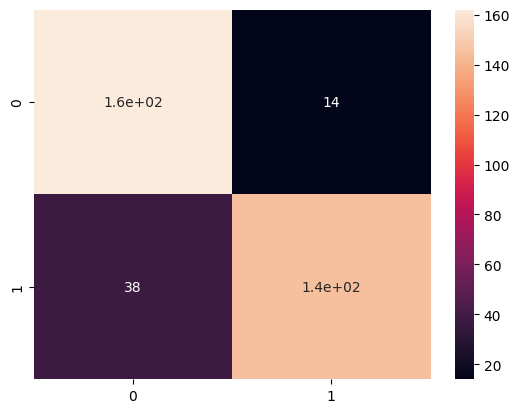

In [50]:
# show confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)